## Importando bibliotecas

In [3]:
# caso precise utilizar GPU
# https://www.youtube.com/watch?v=ryFFCyhTgyA
# !pip install tensorflow-gpu==2.10.0
# 
# import subprocess
# command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# output = subprocess.check_output(command, shell=True, encoding='utf-8')
# for idx, line in enumerate(output.splitlines()):
#     name, memory = line.strip().split(',')
#     print(f"GPU {idx} - Nome {name}, Memória total: {memory} MB")

In [4]:
# comentar esta linha caso use GPU
#!pip install tensorflow

#!pip install pandas yfinance matplotlib scikit-learn joblib pytz python-dateutil pmdarima keras-tuner "numpy<2"

#!pip install statsmodels --upgrade

In [5]:
#from reportlab.rl_settings import verbose
import os
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
import tensorflow as tf

import joblib as jl

from pmdarima import auto_arima
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

## Métodos auxiliares

In [6]:
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

def show_history_details(ticker_history: DataFrame) -> None:
    print(f"Tamanho: {len(ticker_history)}")
    print(f"Data min: {ticker_history.index.min()}")
    print(f"Data max: {ticker_history.index.max()}")


def filter_per_date(history: DataFrame, min_date, max_date) -> DataFrame:
    return history[(history.index >= min_date) & (history.index <= max_date)]


def get_first(dict_tickers_history: dict):
    return next(iter(dict_tickers_history.values()))


def show_dict_tickers_history_details(dict_tickers_history: dict) -> None:
  print(f"Qtd Tickers: {len(dict_tickers_history.keys())}")
  print("Detalhes do primeiro ticker")
  show_history_details(get_first(dict_tickers_history))
  
  
def plot_predictions(test: pd.Series, pred: pd.Series, title: str) -> None:
    # Criando o gráfico
    plt.figure(figsize=(10,6))
    #plt.plot(train.index, train.values, label='Treino')
    plt.plot(test.index, test.values, label='Original')
    plt.plot(pred.index, pred.values, label='Previsto')
    plt.plot()
    
    # Adicionando rótulos e título
    plt.xlabel('Data')
    plt.ylabel('Preços de fechamento')
    plt.title(title)
    plt.legend()
    
    # Exibindo o gráfico
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotacionar as datas para melhor visualização
    plt.tight_layout()  # Ajustar espaçamento
    plt.show()

## Seleção das ações

Para pegar os nomes das ações listadas na B3, fizemos o download de um csv no https://www.dadosdemercado.com.br/acoes.

In [7]:
def get_b3_ticker_symbols() -> list:
    """
    download do csv nesse link: https://www.dadosdemercado.com.br/acoes
    """
    tickers_df = pd.read_csv('acoes-listadas-b3.csv')
    return tickers_df['Ticker'].tolist()

lst_b3_ticker_symbol = get_b3_ticker_symbols()
print(lst_b3_ticker_symbol)

['LREN3', 'B3SA3', 'HAPV3', 'PETR4', 'ENEV3', 'EMBR3', 'ITUB4', 'AZUL4', 'BBDC4', 'ABEV3', 'ITSA4', 'ASAI3', 'COGN3', 'PETZ3', 'PETR3', 'VALE3', 'BBAS3', 'CPLE6', 'RDOR3', 'CSAN3', 'STBP3', 'MGLU3', 'CMIG4', 'GGBR4', 'IFCM3', 'POMO4', 'CXSE3', 'ELET3', 'RENT3', 'RAIL3', 'WEGE3', 'CMIN3', 'VBBR3', 'CVCB3', 'CCRO3', 'UGPA3', 'TIMS3', 'NTCO3', 'RAIZ4', 'QUAL3', 'EQTL3', 'RADL3', 'JBSS3', 'USIM5', 'FLRY3', 'CSNA3', 'SUZB3', 'CRFB3', 'AMER3', 'RRRP3', 'CPLE3', 'AURE3', 'BBDC3', 'HBSA3', 'DXCO3', 'BEEF3', 'SBSP3', 'PRIO3', 'BBSE3', 'BRFS3', 'ONCO3', 'ALOS3', 'MRVE3', 'PCAR3', 'YDUQ3', 'GOLL4', 'GGPS3', 'VAMO3', 'MLAS3', 'TOTS3', 'AZEV4', 'VVEO3', 'BHIA3', 'HYPE3', 'ECOR3', 'CYRE3', 'GOAU4', 'BRKM5', 'VIVT3', 'VIVA3', 'MULT3', 'LWSA3', 'ALPA4', 'OPCT3', 'AZZA3', 'ANIM3', 'BRAP4', 'MRFG3', 'CPFE3', 'JHSF3', 'SIMH3', 'RANI3', 'MOVI3', 'CLSA3', 'SRNA3', 'CURY3', 'POSI3', 'RAPT4', 'ELET6', 'AESB3', 'EGIE3', 'RECV3', 'MATD3', 'DIRR3', 'GFSA3', 'LJQQ3', 'SMFT3', 'BPAN4', 'SAPR4', 'CBAV3', 'TEND3', 

Agora que temos os nomes das ações, iremos fazer o download de todo o histórico delas até o dia 28/12/2023 com a yfinance. Não pegamos os dados de 2024 pois é o ano que estamos realizando este trabalho e mais para frente queremos selecionar um período que contemple cada ano inteiramente. Além disso, pegamos até o dia 28/12 pois é o último dia com histórico do ano de 2023.

In [8]:
max_history_date = "2023-12-28"

def somar_um_dia(date: str) -> str:
    data = datetime.strptime(date, "%Y-%m-%d")
    date = data + timedelta(days=1)
    return date.strftime("%Y-%m-%d")


def download_tickers_history(lst_ticker_symbols: list, max_history_date: str) -> dict:
    # precisamos adicionar '.SA' no final de cada ticker pois é assim que o yfinance espera
    df_tickers = yf.download(".SA ".join(lst_ticker_symbols) + ".SA", end=somar_um_dia(max_history_date), group_by="ticker")
    dict_tickers = {}
    for ticker_symbol in set([t[0] for t in df_tickers.keys()]):
        dict_tickers[ticker_symbol] = df_tickers[ticker_symbol].dropna()
    return dict_tickers


dict_tickers_history = None
if (os.path.exists("dict_tickers_history.pkl")):
    dict_tickers_history = jl.load("dict_tickers_history.pkl")
else:
    dict_tickers_history = download_tickers_history(lst_b3_ticker_symbol, max_history_date)
    jl.dump(dict_tickers_history, "dict_tickers_history.pkl")

In [9]:
get_first(dict_tickers_history).head()

Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-05 00:00:00+00:00,211.000000,220.000000,211.000000,211.000000,62.120045,0.0
2000-01-06 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,28.0
2000-01-07 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-10 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0
2000-01-11 00:00:00+00:00,221.089996,221.089996,221.089996,221.089996,65.090622,0.0


Como podemos ver acima, essas são as informações fornecidas pela yfinance. Agora iremos filtrar as ações que tenham no mínimo 10 anos de histórico até o dia 28/12/2023

In [10]:
def filter_tickers_history_by_age(dict_tickers_history: dict, max_history_date: str, min_age_in_years: int) -> dict:
    dict_tickers = {}
    min_history_date = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=min_age_in_years)
    for t, history in dict_tickers_history.items():
        if not history.empty and history.index.min() < min_history_date:
            dict_tickers[t] = history
    return dict_tickers

dict_tickers_history = filter_tickers_history_by_age(dict_tickers_history, max_history_date, min_age_in_years=10)

print(f"Quantidade de ações: {len(dict_tickers_history)}")

Quantidade de ações: 289


Agora iremos pegar as 100 com maior volume no dia 28/12/2023

In [11]:
def filter_tickers_by_volume(dict_tickers_history: dict, date_filter: str, top: int) -> dict:
    return dict(sorted(dict_tickers_history.items(), key=lambda item: item[1].loc[date_filter, 'Volume'], reverse=True)[:top])

dict_tickers_history = filter_tickers_by_volume(dict_tickers_history, date_filter=max_history_date, top=100)
print(f"Total de tickers: {len(dict_tickers_history)}")
print(f"{'Posição':>3}   {'Ticker Symbol':<13}   {'Volume':>10}")
print("-" * 30)
i = 0    
for ticker, history in dict_tickers_history.items():
    i += 1
    volume = history.loc[max_history_date, "Volume"]
    print(f"{i}   {ticker:<13}   {volume:>10,.2f}")

Total de tickers: 100
Posição   Ticker Symbol       Volume
------------------------------
1   CVCB3.SA        71,001,900.00
2   EMBR3.SA        25,890,400.00
3   ITSA4.SA        23,414,900.00
4   PETR4.SA        21,421,900.00
5   CIEL3.SA        20,929,200.00
6   B3SA3.SA        20,491,200.00
7   VALE3.SA        16,545,800.00
8   ABEV3.SA        16,500,300.00
9   BBDC4.SA        14,852,700.00
10   COGN3.SA        14,615,200.00
11   GFSA3.SA        13,601,100.00
12   MRVE3.SA        13,504,400.00
13   CMIG4.SA        13,371,410.00
14   MGLU3.SA        12,859,371.00
15   ITUB4.SA        12,555,300.00
16   TRPL4.SA        12,457,500.00
17   PETR3.SA        11,746,400.00
18   LREN3.SA        11,687,800.00
19   BBAS3.SA        11,680,800.00
20   POMO4.SA        11,418,400.00
21   CPLE3.SA        11,054,700.00
22   ALPA4.SA        10,988,900.00
23   CPLE6.SA        9,721,200.00
24   ENEV3.SA        9,185,800.00
25   PDGR3.SA        8,253,900.00
26   FLRY3.SA        8,182,700.00
27   PRIO3.SA

Agora temos um dicionário chamado ```dict_tickers_history``` com as 100 ações mais negociados do dia 28/12/2023. Onde a chave é o nome do ticker da ação, e o valor é o histórico de valores.

## Tratamento dos dados

Iremos retirar do histórico as datas que não fazem parte dos 10 anos de histórico

In [12]:
def cut_tickers_history(dict_tickers_history: dict, max_history_date: str, years_to_intact: int) -> dict:
  data_min = pytz.utc.localize(datetime.strptime(max_history_date, "%Y-%m-%d")) - relativedelta(years=years_to_intact)
  for t, history in dict_tickers_history.items():
    dict_tickers_history[t] = history[history.index > data_min]
  return dict_tickers_history

print("Antes: ")
show_dict_tickers_history_details(dict_tickers_history)
dict_tickers_history = cut_tickers_history(dict_tickers_history, max_history_date, years_to_intact=10)
print("")
print("Depois: ")
show_dict_tickers_history_details(dict_tickers_history)

Antes: 
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 2498
Data min: 2013-12-09 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00

Depois: 
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 2485
Data min: 2013-12-30 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00


Como podemos o exemplo acima, foram removidos o histórico do dia 09/12/2013 a 29/12/2013 da primeira ação. O próximo passo é deixar apenas as colunas da data (Date) e o último valor da ação no dia (Close) 

In [13]:
for ticker, history in dict_tickers_history.items():
    dict_tickers_history[ticker] = DataFrame(history["Close"])

get_first(dict_tickers_history).head()

,Close
Date,
2013-12-30 00:00:00+00:00,12.610100
2014-01-02 00:00:00+00:00,12.898567
2014-01-03 00:00:00+00:00,13.104614
2014-01-06 00:00:00+00:00,13.187033
2014-01-07 00:00:00+00:00,13.187033


Agora iremos separar 50% dos dados para treino e 50% para teste

In [14]:
def split_train_test(dict_tickers_history: dict, train_size: float) -> tuple[dict, dict]:
  train = {}
  test = {}
  for t, h in dict_tickers_history.items():
    limiar = int(len(h) * train_size)
    train[t] = h.iloc[:limiar]
    test[t] = h.iloc[limiar:]
  return train, test

dict_train_history, dict_test_history = split_train_test(dict_tickers_history, train_size = 0.8)
print("Treino")
show_dict_tickers_history_details(dict_train_history)
print("")
print("Teste")
show_dict_tickers_history_details(dict_test_history)

Treino
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 1988
Data min: 2013-12-30 00:00:00+00:00
Data max: 2022-01-03 00:00:00+00:00

Teste
Qtd Tickers: 100
Detalhes do primeiro ticker
Tamanho: 497
Data min: 2022-01-04 00:00:00+00:00
Data max: 2023-12-28 00:00:00+00:00


In [15]:
def normalize_series(series):
    scaler = MinMaxScaler()
    normalized_series = scaler.fit_transform(series.reshape(-1, 1))
    return normalized_series.flatten(), scaler

for ticker, train_history in dict_train_history.items():
    normalized_series, train_scaler = normalize_series(train_history["Close"].values)
    train_history["Normalized"] = normalized_series
    test_history = dict_test_history[ticker]
    test_history["Normalized"] = train_scaler.transform(test_history["Close"].values.reshape(-1, 1))

display(get_first(dict_train_history))
display(get_first(dict_test_history))
    # display(get_first(dict_test_history))

,Close,Normalized
Date,,
2013-12-30 00:00:00+00:00,12.610100,0.151089
2014-01-02 00:00:00+00:00,12.898567,0.157091
2014-01-03 00:00:00+00:00,13.104614,0.161379
2014-01-06 00:00:00+00:00,13.187033,0.163094
2014-01-07 00:00:00+00:00,13.187033,0.163094
...,...,...
2021-12-27 00:00:00+00:00,12.528393,0.149389
2021-12-28 00:00:00+00:00,12.920190,0.157541
2021-12-29 00:00:00+00:00,11.972588,0.137824


,Close,Normalized
Date,,
2022-01-04 00:00:00+00:00,10.961205,0.116779
2022-01-05 00:00:00+00:00,10.195834,0.100853
2022-01-06 00:00:00+00:00,10.305173,0.103128
2022-01-07 00:00:00+00:00,10.505627,0.107299
2022-01-10 00:00:00+00:00,10.560296,0.108437
...,...,...
2023-12-21 00:00:00+00:00,3.960000,-0.028902
2023-12-22 00:00:00+00:00,3.960000,-0.028902
2023-12-26 00:00:00+00:00,3.980000,-0.028486


## Predições



### Auxiliares

In [16]:
max_window_size = 7

# Função para reverter a normalização
def inverse_normalization(series_normalized, scaler):
    return scaler.inverse_transform(series_normalized.reshape(-1, 1)).flatten()



### ARIMA

In [38]:
def predizer_precos_com_arima(train: np.array, train_scaler: MinMaxScaler, test: np.array, test_dates: pd.DatetimeIndex, max_window_size) -> pd.DataFrame:        
    # encontra os melhores hiperarametros para o arima utilizando o conjunto de dados de treino
    best_arima_model = auto_arima(
        train,
        max_p=max_window_size,
        max_q=max_window_size,
        seasonal=False,
        trace=False,
        n_jobs=-1, # paralelizacao
        error_action='ignore',suppress_warnings=True,
        stepwise=False # optimizacao
    )
    
    # tenta prever os valores de teste. Para prever o valor de teste 'N', o valor de teste 'N-1' eh adicionado na 
    # lista de treinamento (nomeado como 'history'). Assim, a cada iteracao do 'for' eh treinado um novo ARIMA 
    # mas com os mesmos hiperparametros selecionados acima.
    predictions = list()
    history = [x for x in train]
    for time_point in range(len(test)):
        model = ARIMA(history, order=best_arima_model.order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps = 1)
        predictions.append(yhat[0])
        history.append(test[time_point])
    predictions = np.array(predictions)    
    
    return pd.DataFrame({"Predictions": inverse_normalization(predictions, train_scaler)}, index=test_dates)


def predizer_todas_as_acoes_com_arima(dict_train_history, dict_test_history, max_window_size):
    # carrega as predicoes salvas em arquivo
    arima_file_name = "dict_arima_pred_results.pkl"
    if (os.path.exists(arima_file_name)):
        dict_pred = jl.load(arima_file_name)
    else:
        dict_pred = dict()
    
    progress = 0 # para mostrar o progresso no terminal
    
    # preve os precos das acoes do ticker e armazena em um dicionario
    for ticker_name, train_history in dict_train_history.items():
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        
        # Preve os valores do ticker caso nao tenha sido previsto ainda. Caso contrario vai para o proximo ticker
        if not dict_pred.__contains__(ticker_name):
            _, scaler = normalize_series(train_history["Close"].values)
            test_history = dict_test_history[ticker_name]
            pred = predizer_precos_com_arima(
                train=train_history["Normalized"].values, 
                train_scaler=scaler, 
                test=test_history["Normalized"].values,
                test_dates=test_history.index,
                max_window_size=max_window_size
            )
            dict_pred[ticker_name] = pred
            
            # salva as predicoes em arquivo para nao perder tempo de processamento caso pare o codigo
            jl.dump(dict_pred, arima_file_name)
    
    return dict_pred

dict_arima_pred_results = predizer_todas_as_acoes_com_arima(dict_train_history, dict_test_history, max_window_size)

Progresso: 1 - CVCB3.SA
Progresso: 2 - EMBR3.SA
Progresso: 3 - ITSA4.SA
Progresso: 4 - PETR4.SA
Progresso: 5 - CIEL3.SA
Progresso: 6 - B3SA3.SA


KeyboardInterrupt: 

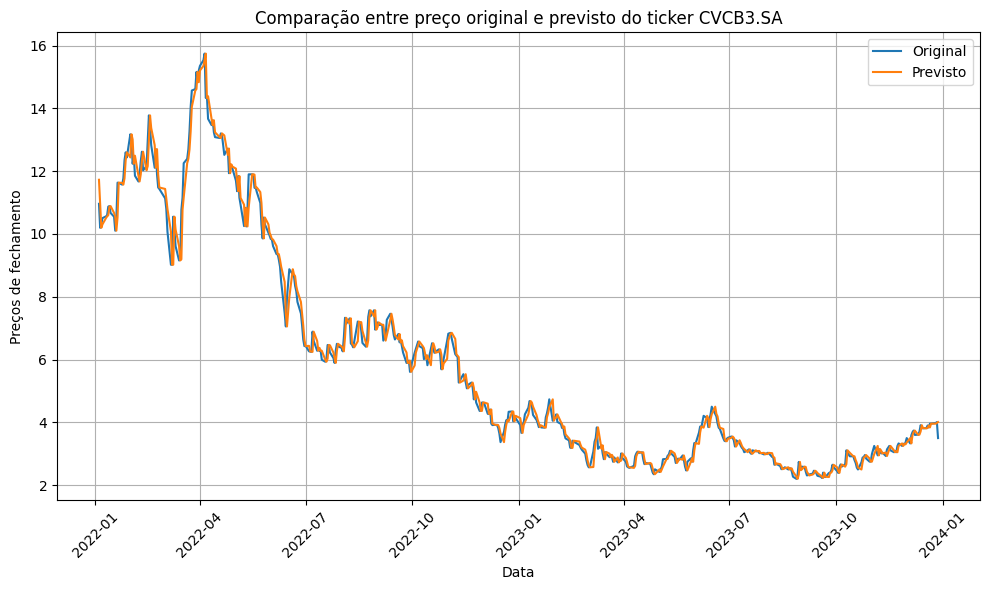

In [17]:
ticker_name = "CVCB3.SA"
plot_predictions(
    test=dict_test_history[ticker_name]["Close"],
    pred=dict_arima_pred_results[ticker_name]["Predictions"],
    title=f"Comparação entre preço original e previsto do ticker {ticker_name}"
)

### LSTM

In [20]:
def get_windows(train: pd.Series, test: pd.Series, window_size: int):    
    # prepara windows para treino
    window_train = pd.DataFrame({"d": train.values}, index=train.index)
    for s in range(1, window_size):
        window_train[f"d+{s}"] = window_train["d"].shift(-s)
    X_train = window_train.dropna().reset_index(drop=True)
    X_train = X_train.iloc[:-1] # remove ultima janela pois ela nao tem um y_train respectivo
    y_train = window_train[["d"]].iloc[window_size:].reset_index(drop=True)
    
    # prepara windows para teste
    window_test = pd.DataFrame({"d": test.values}, index=test.index)
    train_final = pd.DataFrame({"d": train.values[-window_size:]}, index=train.index[-window_size:])
    window_test = pd.concat([train_final, window_test]).sort_index() # concatena com o final dos dados de treino
    for s in range(1, window_size):
        window_test[f"d+{s}"] = window_test["d"].shift(-s)
    X_test = window_test.dropna().reset_index(drop=True)
    X_test = X_test.iloc[:-1] # remove ultima janela pois ela nao tem um y_test respectivo
    y_test = window_test[['d']].iloc[window_size:].reset_index(drop=True)
    
    return X_train,X_test,y_train,y_test

# mostra exemplo de como ficou
X_train, X_test, y_train, y_test = get_windows(get_first(dict_train_history)["Close"], get_first(dict_test_history)["Close"], window_size=max_window_size)
display(X_train)
display(y_train)
display(X_test)
display(y_test)

,d,d+1,d+2,d+3,d+4,d+5,d+6
0,12.610100,12.898567,13.104614,13.187033,13.187033,13.022195,13.063405
1,12.898567,13.104614,13.187033,13.187033,13.022195,13.063405,13.129340
2,13.104614,13.187033,13.187033,13.022195,13.063405,13.129340,13.022195
3,13.187033,13.187033,13.022195,13.063405,13.129340,13.022195,12.857357
4,13.187033,13.022195,13.063405,13.129340,13.022195,12.857357,12.939776
...,...,...,...,...,...,...,...
1976,14.259589,13.940685,13.840458,12.628620,12.901967,12.892855,12.555728
1977,13.940685,13.840458,12.628620,12.901967,12.892855,12.555728,12.528393
1978,13.840458,12.628620,12.901967,12.892855,12.555728,12.528393,12.920190
1979,12.628620,12.901967,12.892855,12.555728,12.528393,12.920190,11.972588


,d
0,13.129340
1,13.022195
2,12.857357
3,12.939776
4,12.651310
...,...
1976,12.528393
1977,12.920190
1978,11.972588
1979,12.227712


,d,d+1,d+2,d+3,d+4,d+5,d+6
0,12.892855,12.555728,12.528393,12.920190,11.972588,12.227712,11.726576
1,12.555728,12.528393,12.920190,11.972588,12.227712,11.726576,10.961205
2,12.528393,12.920190,11.972588,12.227712,11.726576,10.961205,10.195834
3,12.920190,11.972588,12.227712,11.726576,10.961205,10.195834,10.305173
4,11.972588,12.227712,11.726576,10.961205,10.195834,10.305173,10.505627
...,...,...,...,...,...,...,...
492,3.710000,3.910000,3.820000,3.810000,3.820000,3.900000,3.840000
493,3.910000,3.820000,3.810000,3.820000,3.900000,3.840000,3.960000
494,3.820000,3.810000,3.820000,3.900000,3.840000,3.960000,3.960000
495,3.810000,3.820000,3.900000,3.840000,3.960000,3.960000,3.980000


,d
0,10.961205
1,10.195834
2,10.305173
3,10.505627
4,10.560296
...,...
492,3.960000
493,3.960000
494,3.980000
495,4.010000


In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

def predizer_precos_com_lstm(train: pd.Series, test: pd.Series, train_scaler: MinMaxScaler, max_look_back: int) -> pd.DataFrame:        
    best_model = None
    best_mse = None
    best_look_back = None
    # tenta encontrar o melhor lag
    for look_back in range(1, max_look_back+1):    
        # constroi estrutura do LSTM
        model = Sequential()
        model.add(LSTM( # primeira camada
            units=100,
            activation='tanh', 
            return_sequences=True,
            input_shape=(look_back, 1)
        ))
        model.add(Dropout(0.1))
        model.add(LSTM( # segunda camada
            units=50,
            activation='tanh', 
            return_sequences=True,
            input_shape=(look_back, 1)
        ))
        model.add(Dropout(0.1))
        model.add(Dense(1)) # camada densa de saída
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
        # converte train em janelas de tempo
        X_train, _, y_train, _ = get_windows(train, test, window_size=look_back)
        X_train = X_train.values.reshape(len(X_train), look_back, 1)
        y_train = y_train.values.reshape(-1, 1)
        
        # treina o modelo com 70% treino e 30% validacao
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        hist = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        
        # pega mean square error da melhor epoca restaurada pelo early_stopping
        val_mse = hist.history["val_mse"][np.argmin(hist.history["val_loss"])]
        
        # verifica se foi o melhor
        if best_model is None or val_mse < best_mse:
            best_model = model
            best_mse = val_mse
            best_look_back = look_back
    
    # preve test com o melhor modelo
    _, X_test, _, _ = get_windows(train, test, window_size=best_look_back) # converte test em janelas de tempo
    X_test = X_test.values.reshape(len(X_test), best_look_back, 1)
    predictions = best_model.predict(X_test, verbose=0)
    predictions = inverse_normalization(predictions.flatten(), train_scaler)
    return pd.DataFrame({"Predictions": predictions}, index=test.index)


def predizer_todas_as_acoes_com_lstm(dict_train_history, dict_test_history, max_look_back):
    # carrega as predicoes salvas em arquivo
    lstm_file_name = "dict_lstm_pred_results.pkl"
    if (os.path.exists(lstm_file_name)):
        dict_pred = jl.load(lstm_file_name)
    else:
        dict_pred = dict()
    
    progress = 0 # para mostrar o progresso no terminal
    
    # preve os precos das acoes do ticker e armazena em um dicionario
    for ticker_name, train_history in dict_train_history.items():
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        
        # Preve os valores do ticker caso nao tenha sido previsto ainda. Caso contrario vai para o proximo ticker
        if not dict_pred.__contains__(ticker_name):
            _, scaler = normalize_series(train_history["Close"].values)
            test_history = dict_test_history[ticker_name]
            pred = predizer_precos_com_lstm(
                train=train_history["Normalized"], 
                train_scaler=scaler, 
                test=test_history["Normalized"],
                max_look_back=max_look_back
            )
            dict_pred[ticker_name] = pred
            
            # salva as predicoes em arquivo para nao perder tempo de processamento caso pare o codigo
            jl.dump(dict_pred, lstm_file_name)
    
    return dict_pred

dict_lstm_pred_results = predizer_todas_as_acoes_com_lstm(dict_train_history, dict_test_history, max_window_size)

Progresso: 1 - CVCB3.SA
Progresso: 2 - EMBR3.SA
16/16 [==============================] - 1s 6ms/step


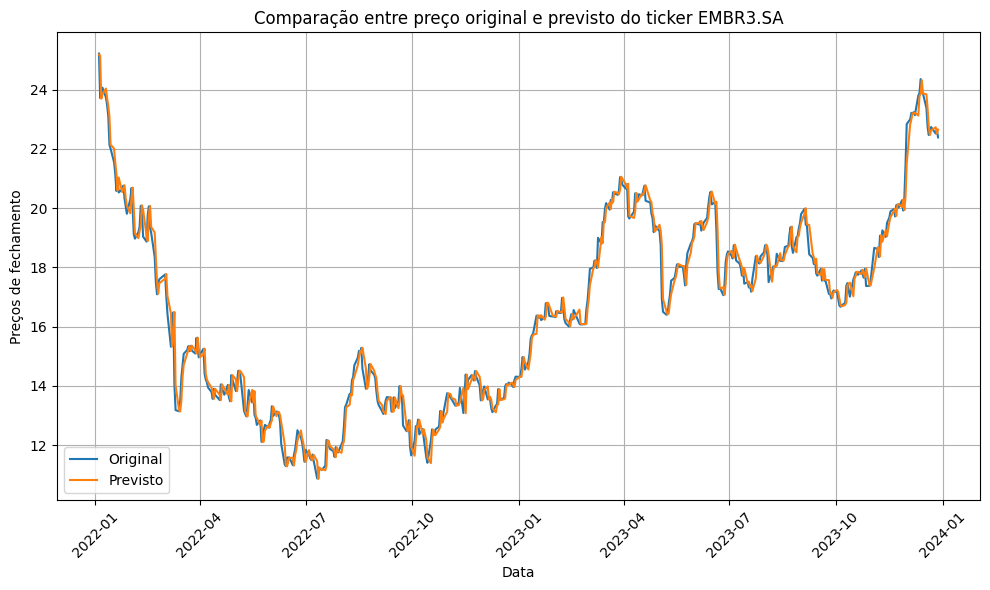

In [35]:
ticker_name = "EMBR3.SA"
plot_predictions(
    test=dict_test_history[ticker_name]["Close"],
    pred=dict_lstm_pred_results[ticker_name]["Predictions"],
    title=f"Comparação entre preço original e previsto do ticker {ticker_name}"
)

### Método ingênuo

In [44]:
def predizer_precos_com_ingenuo(train: pd.Series, test: pd.Series, train_scaler: MinMaxScaler) -> pd.DataFrame:
    predictions = list()
    predictions.append(train.values[-1])
    for p in test.values[:-1]:
        predictions.append(p)
    predictions = np.array(predictions)
    predictions = inverse_normalization(predictions.flatten(), train_scaler)
    return pd.DataFrame({"Predictions": predictions}, index=test.index)
    

def predizer_todas_as_acoes_com_ingenuo(dict_train_history, dict_test_history):
    progress = 0 # para mostrar o progresso no terminal

    # preve os precos das acoes do ticker e armazena em um dicionario
    dict_pred = dict()
    for ticker_name, train_history in dict_train_history.items():
        progress += 1
        print(f"Progresso: {progress} - {ticker_name}")
        
        # Preve os valores do ticker caso nao tenha sido previsto ainda. Caso contrario vai para o proximo ticker
        if not dict_pred.__contains__(ticker_name):
            _, scaler = normalize_series(train_history["Close"].values)
            test_history = dict_test_history[ticker_name]
            dict_pred[ticker_name] = predizer_precos_com_ingenuo(
                train=train_history["Normalized"],
                test=test_history["Normalized"],
                train_scaler=scaler
            )
    
    return dict_pred

dict_ingenuo_pred_results = predizer_todas_as_acoes_com_ingenuo(dict_train_history, dict_test_history)

Progresso: 1 - CVCB3.SA
Progresso: 2 - EMBR3.SA
Progresso: 3 - ITSA4.SA
Progresso: 4 - PETR4.SA
Progresso: 5 - CIEL3.SA
Progresso: 6 - B3SA3.SA
Progresso: 7 - VALE3.SA
Progresso: 8 - ABEV3.SA
Progresso: 9 - BBDC4.SA
Progresso: 10 - COGN3.SA
Progresso: 11 - GFSA3.SA
Progresso: 12 - MRVE3.SA
Progresso: 13 - CMIG4.SA
Progresso: 14 - MGLU3.SA
Progresso: 15 - ITUB4.SA
Progresso: 16 - TRPL4.SA
Progresso: 17 - PETR3.SA
Progresso: 18 - LREN3.SA
Progresso: 19 - BBAS3.SA
Progresso: 20 - POMO4.SA
Progresso: 21 - CPLE3.SA
Progresso: 22 - ALPA4.SA
Progresso: 23 - CPLE6.SA
Progresso: 24 - ENEV3.SA
Progresso: 25 - PDGR3.SA
Progresso: 26 - FLRY3.SA
Progresso: 27 - PRIO3.SA
Progresso: 28 - USIM5.SA
Progresso: 29 - GOLL4.SA
Progresso: 30 - MRFG3.SA
Progresso: 31 - GOAU4.SA
Progresso: 32 - BRFS3.SA
Progresso: 33 - PCAR3.SA
Progresso: 34 - BEEF3.SA
Progresso: 35 - GGBR4.SA
Progresso: 36 - ANIM3.SA
Progresso: 37 - ELET3.SA
Progresso: 38 - UGPA3.SA
Progresso: 39 - CSAN3.SA
Progresso: 40 - BHIA3.SA
Progresso

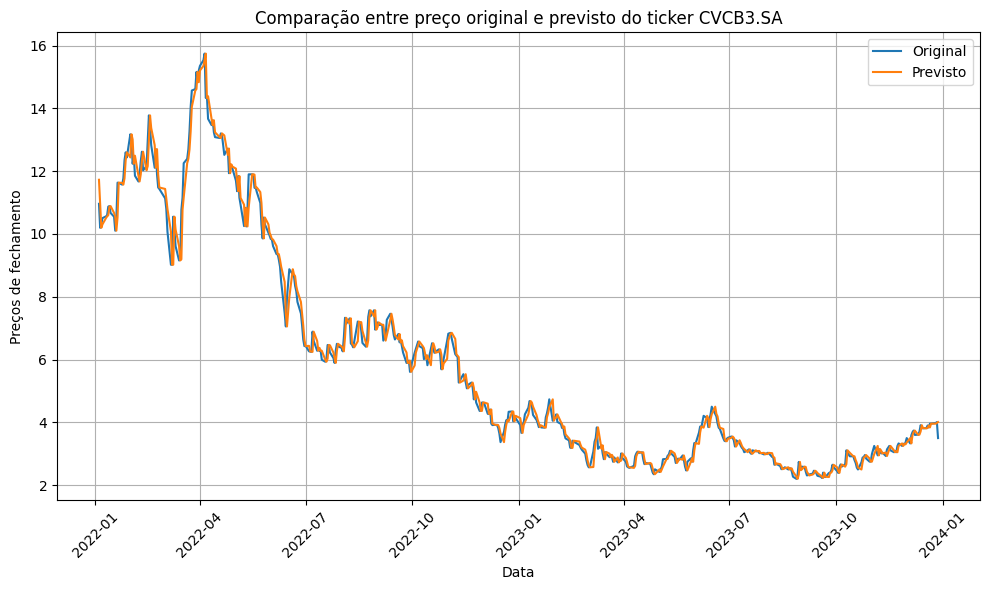

In [45]:
ticker_name = "CVCB3.SA"
plot_predictions(
    test=dict_test_history[ticker_name]["Close"],
    pred=dict_ingenuo_pred_results[ticker_name]["Predictions"],
    title=f"Comparação entre preço original e previsto do ticker {ticker_name}"
)

### Analisando resultados

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


def separar_test_em_periodos(history: dict) -> dict:
    h2 = {
        "1 mês": dict(),
        "3 meses": dict(),
        "6 meses": dict(),
        "1 ano": dict(),
        "3 anos": dict(),
        "5 anos": dict()
    }
    for ticker, h in history.items():
        min_date = h.index.min()
        h2["1 mês"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=1))
        h2["3 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=3))
        h2["6 meses"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(months=6))
        h2["1 ano"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=1))
        h2["3 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=3))
        h2["5 anos"][ticker] = filter_per_date(h, min_date, max_date=min_date + pd.DateOffset(years=5))
    return h2


def calculate_mapes(dict_pred_results, test_history):
    dict_mape = dict()
    for periodo, dict_modelo in dict_pred_results.items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            for ticker_name, y_pred in dict_ticker_name.items():
                if not dict_mape.__contains__(periodo):
                    dict_mape[periodo] = {"arima": dict(), "lstm": dict()}
                h = test_history[ticker_name]
                h = h.loc[h.index.isin(test_history[ticker_name].index)]
                dict_mape[periodo][modelo][ticker_name] = mean_absolute_percentage_error(y_true=get_prices(h), y_pred=y_pred[:len(h)]) * 100
    return dict_mape


def calculate_mape_means(dict_pred_results, test_history):
    dict_mape_means = dict()
    for periodo, dict_modelo in calculate_mapes(dict_pred_results, test_history).items():
        for modelo, dict_ticker_name in dict_modelo.items():        
            sum = 0
            n = 0
            for _, mape in dict_ticker_name.items():
                sum += mape
                n+= 1
            if not dict_mape_means.__contains__(periodo):
                dict_mape_means[periodo] = dict()
            dict_mape_means[periodo][modelo] = float(sum / n) # media dos mapes
    return dict_mape_means


def mostrar_grafico_mapes(dict_pred_results, test_history):
    # Extrair os períodos, os valores do ARIMA e do LSTM
    for periodo, test in separar_test_em_periodos(test_history).items():
        dict_mape_means = calculate_mape_means(dict_pred_results, test)
        periodos = list(dict_mape_means.keys())
        arima_values = [dict_mape_means[periodo]['arima'] for periodo in periodos]
        lstm_values = [dict_mape_means[periodo]['lstm'] for periodo in periodos]
        
        # Configurações do gráfico
        bar_width = 0.35
        index = np.arange(len(periodos))
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Criar as barras
        ax.bar(index, arima_values, bar_width, label='ARIMA', color='b')
        ax.bar(index + bar_width, lstm_values, bar_width, label='LSTM', color='g')
        
        # Título e labels
        ax.set_xlabel('Períodos de treinamento')
        ax.set_ylabel('MAPE médio (%)')
        ax.set_title(f'Comparação entre ARIMA, LSTM e método ingênuo por Período de treinamento prevendo {periodo}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(periodos)
        ax.legend()
        
        # Exibir o gráfico
        plt.tight_layout()
        plt.show()
        
mostrar_grafico_mapes(dict_pred_results, dict_test_history)